In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline
import quandl
data = quandl.get('BCHARTS/KRAKENUSD', returns='pandas')
data['Weighted Price'].replace(0, np.nan, inplace=True)
data['Weighted Price'].fillna(method='ffill', inplace=True)
btc_trace = go.Scatter(x=data.index, y=data['Weighted Price'], name= 'Price')
py.iplot([btc_trace])

Using TensorFlow backend.


In [2]:
#gdax = quandl.get('GDAX/USD', returns='pandas')

#kraken = quandl.get('BCHARTS/KRAKENUSD', returns='pandas')
#kraken["Weighted Price"][:1032]

#gdax["WP"] = (gdax["Open"][0] + gdax["High"][0] + gdax["Low"][0])/3

data.head()


,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


In [ ]:
#for i in range(0,1032):
    #gdax["WP"][i] = (gdax["Open"][i] + gdax["High"][i] + gdax["Low"][i])/3
    

In [47]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
values = data[['Weighted Price'] + ['Volume (BTC)'] + ['Volume (Currency)']].values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
#reframed = series_to_supervised(values, 1, 1)
reframed.drop(reframed.columns[[4,5]], axis=1, inplace=True)
#taking weighted volume and volumeC and next days weighted to predict 

values = reframed.values
n_train_hours = int(len(values) * 0.75)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
look_back = 1

# reshape input to be 3D [samples, timesteps, features]

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
predictDates = data.tail(len(testX)).index

1074
358


In [48]:
model = Sequential()
model.add(LSTM(300,dropout=0.1 ,return_state=False,input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Dense(64, activation='linear'))
model.add(Dense(1))


model.compile(loss='mae', optimizer='adam')
multi_history = model.fit(train_X, train_y, epochs=300, batch_size=100, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Train on 1075 samples, validate on 359 samples
Epoch 1/300
1075/1075 [==============================] - 1s 1ms/step - loss: 448.0932 - val_loss: 3165.0002
Epoch 2/300
1075/1075 [==============================] - 0s 63us/step - loss: 446.9333 - val_loss: 3163.6255
Epoch 3/300
1075/1075 [==============================] - 0s 68us/step - loss: 445.7846 - val_loss: 3162.4456
Epoch 4/300
1075/1075 [==============================] - 0s 68us/step - loss: 444.5949 - val_loss: 3161.0676
Epoch 5/300
1075/1075 [==============================] - 0s 68us/step - loss: 443.1886 - val_loss: 3159.6241
Epoch 6/300
1075/1075 [==============================] - 0s 69us/step - loss: 441.6862 - val_loss: 3158.0580
Epoch 7/300
1075/1075 [==============================] - 0s 67us/step - loss: 439.9232 - val_loss: 3156.1125
Epoch 8/300
1075/1075 [==============================] - 0s 68us/step - loss: 437.9470 - val_loss: 3153.9158
Epoch 9/300
1075/1075 [==============================] - 0s 69us/step - loss: 435.

1075/1075 [==============================] - 0s 69us/step - loss: 251.9982 - val_loss: 2965.9211
Epoch 76/300
1075/1075 [==============================] - 0s 69us/step - loss: 248.7733 - val_loss: 2963.1367
Epoch 77/300
1075/1075 [==============================] - 0s 66us/step - loss: 245.4359 - val_loss: 2960.0130
Epoch 78/300
1075/1075 [==============================] - 0s 68us/step - loss: 242.9129 - val_loss: 2957.2530
Epoch 79/300
1075/1075 [==============================] - 0s 65us/step - loss: 239.8385 - val_loss: 2954.5304
Epoch 80/300
1075/1075 [==============================] - 0s 67us/step - loss: 237.2392 - val_loss: 2951.6889
Epoch 81/300
1075/1075 [==============================] - 0s 68us/step - loss: 234.3051 - val_loss: 2948.9790
Epoch 82/300
1075/1075 [==============================] - 0s 67us/step - loss: 232.3912 - val_loss: 2946.3071
Epoch 83/300
1075/1075 [==============================] - 0s 66us/step - loss: 229.6247 - val_loss: 2943.5089
Epoch 84/300
1075/1075 

1075/1075 [==============================] - 0s 64us/step - loss: 167.6248 - val_loss: 2840.7414
Epoch 150/300
1075/1075 [==============================] - 0s 61us/step - loss: 167.3231 - val_loss: 2839.6359
Epoch 151/300
1075/1075 [==============================] - 0s 62us/step - loss: 166.7026 - val_loss: 2838.5454
Epoch 152/300
1075/1075 [==============================] - 0s 61us/step - loss: 165.5220 - val_loss: 2837.1507
Epoch 153/300
1075/1075 [==============================] - 0s 63us/step - loss: 165.1855 - val_loss: 2836.0375
Epoch 154/300
1075/1075 [==============================] - 0s 67us/step - loss: 165.0718 - val_loss: 2834.9441
Epoch 155/300
1075/1075 [==============================] - 0s 64us/step - loss: 164.4856 - val_loss: 2833.8695
Epoch 156/300
1075/1075 [==============================] - 0s 64us/step - loss: 163.9388 - val_loss: 2832.8086
Epoch 157/300
1075/1075 [==============================] - 0s 64us/step - loss: 164.0170 - val_loss: 2831.7531
Epoch 158/300
1

Epoch 223/300
1075/1075 [==============================] - 0s 84us/step - loss: 147.1608 - val_loss: 2777.0914
Epoch 224/300
1075/1075 [==============================] - 0s 87us/step - loss: 146.8055 - val_loss: 2776.4964
Epoch 225/300
1075/1075 [==============================] - 0s 87us/step - loss: 146.5923 - val_loss: 2775.9042
Epoch 226/300
1075/1075 [==============================] - 0s 78us/step - loss: 146.7393 - val_loss: 2775.3110
Epoch 227/300
1075/1075 [==============================] - 0s 86us/step - loss: 146.3828 - val_loss: 2774.7301
Epoch 228/300
1075/1075 [==============================] - 0s 91us/step - loss: 146.7155 - val_loss: 2774.1565
Epoch 229/300
1075/1075 [==============================] - 0s 80us/step - loss: 146.1036 - val_loss: 2773.5934
Epoch 230/300
1075/1075 [==============================] - 0s 78us/step - loss: 145.9273 - val_loss: 2773.0336
Epoch 231/300
1075/1075 [==============================] - 0s 85us/step - loss: 145.8416 - val_loss: 2772.4756
E

Epoch 297/300
1075/1075 [==============================] - 0s 75us/step - loss: 143.0347 - val_loss: 2750.3408
Epoch 298/300
1075/1075 [==============================] - 0s 76us/step - loss: 142.8824 - val_loss: 2750.1034
Epoch 299/300
1075/1075 [==============================] - 0s 73us/step - loss: 142.9712 - val_loss: 2749.8563
Epoch 300/300
1075/1075 [==============================] - 0s 73us/step - loss: 142.8988 - val_loss: 2749.6078


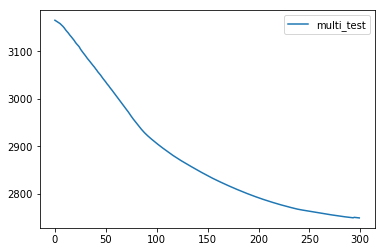

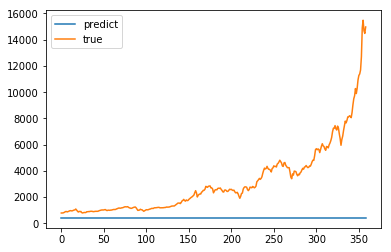

In [49]:

pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()
yhat = model.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()



In [50]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 59063388.309


In [51]:

actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')
py.iplot([ multi_predict_chart, actual_chart])

In [ ]:
#from keras.models import load_model

#model.save('166RMSE_model.h5')  # creates a HDF5 file 'my_model.h5'

#model = load_model('my_model.h5')